In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

Unsupervised metric learning via K-ISOMAP for high-dimensional data clustering - Noise experiments

Created on Wed May 09 14:55:26 2024

"""
# Imports
import sys
import time
import warnings
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sklearn.datasets as skdata
import sklearn.neighbors as sknn
import sklearn.utils.graph as sksp
from numpy import log
from numpy import trace
from numpy import dot
from numpy import sqrt
from numpy.linalg import det
from numpy.linalg import inv
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics.cluster import mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import davies_bouldin_score
from kisomap_latest import PlotaDados, KIsomap, Clustering
import umap
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import interactive

# To avoid unnecessary warning messages
warnings.simplefilter(action='ignore')

# Double Torus 3D

Aqui estão os gráficos do Toro.

In [ ]:
#knnGraph = sknn.kneighbors_graph(result_matrix[:,:3], n_neighbors=4, mode='distance')
#A = knnGraph.toarray()

In [113]:
# Parameters
u = np.linspace(0, 2*np.pi, 26)
v = np.linspace(0, 2*np.pi, 26)
U, V = np.meshgrid(u, v)
#noise_scale = 0.2  # adjust the noise gaussian parameter here

R = 5
r = 1

# S-Surface equation
x = (R+r*np.cos(V))*np.cos(U)
y = (R+r*np.cos(V))*np.sin(U)-5
z = r*np.sin(V)


x_1 = r*np.sin(V) 
y_1 = (R+r*np.cos(V))*np.sin(U) 
z_1 = (R+r*np.cos(V))*np.cos(U)

np.random.seed(127)
# Add Gaussian noise with 0.1 standard deviation
noise_matrix = np.random.normal(0, 0.3, (len(z.flatten()), 3))
data_matrix = np.column_stack((x.flatten(), y.flatten(), z.flatten())) + noise_matrix
noise_matrix_1 = np.random.normal(0, 0.3, (len(z_1.flatten()), 3))
data_matrix_1 = np.column_stack((x_1.flatten(), y_1.flatten(), z_1.flatten())) + noise_matrix_1

result_matrix = np.vstack([np.column_stack((data_matrix, np.full(len(z.flatten()), 0.2))), 
                          np.column_stack((data_matrix_1, np.full(len(z_1.flatten()), 0.8)))]).astype('float64')

In [27]:
def plot_3d(elev=30, azim=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    scatter = ax.scatter(result_matrix.T[0], result_matrix.T[1], result_matrix.T[2], 
                         c=[cm.rainbow(valor) for valor in result_matrix.T[3]], 
                         marker='.', alpha=0.5)
    plt.show()

interactive_plot = interactive(plot_3d, elev=(0, 90, 10), azim=(0, 360, 10))
interactive_plot

interactive(children=(IntSlider(value=30, description='elev', max=90, step=10), IntSlider(value=30, descriptio…

In [114]:
nn = int(np.floor(round(sqrt(result_matrix[:,:3].shape[0]))))

dados_kisomap =  KIsomap(result_matrix[:,:3],k=nn, d=2,option=0)
df_kisomap = pd.DataFrame(dados_kisomap,columns=['x','y'])

model = Isomap(n_neighbors=nn, n_components=2)
dados_isomap = model.fit_transform(result_matrix[:,:3])
dados_isomap = dados_isomap.T

reducer = umap.UMAP(n_neighbors=nn)
embedding = reducer.fit_transform(result_matrix[:,:3])

In [35]:
dados=result_matrix[:,:3]
n = result_matrix[:,:3].shape[0]
m = result_matrix[:,:3].shape[1]
k = round(np.sqrt(result_matrix[:,:3].shape[0]))

matriz_pcs = np.zeros((n, m, m))

knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
A = knnGraph.toarray()

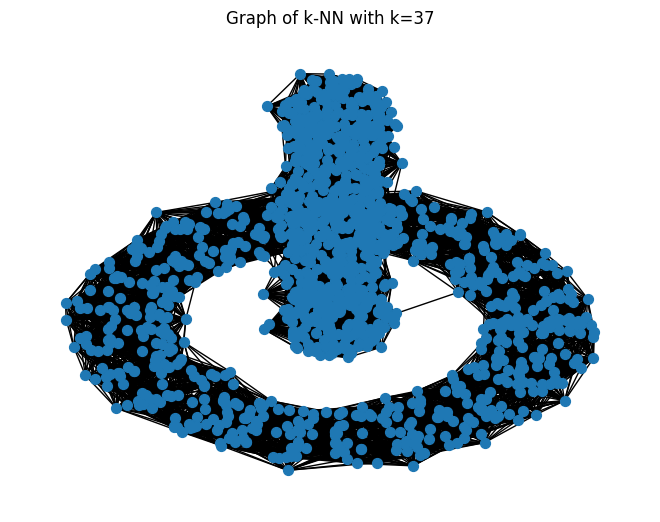

In [36]:
# Gerar dados

# Configurar k-NN
#k = 25
nbrs = NearestNeighbors(n_neighbors=k).fit(result_matrix[:,:3])
distances, indices = nbrs.kneighbors(result_matrix[:,:3])

# Criar o grafo com NetworkX
G = nx.Graph()

# Adicionar nós
for i in range(result_matrix[:,:3].shape[0]):
    G.add_node(i, pos=(result_matrix[:,:3][i, 0], result_matrix[:,:3][i, 1]))

# Adicionar arestas
for i in range(indices.shape[0]):
    for j in range(1, k):  # começar de 1 para evitar conectar o nó a ele mesmo
        G.add_edge(i, indices[i, j])

# Desenhar o grafo
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=50, with_labels=False)
plt.title(f'Graph of k-NN with k={k}')
plt.show()

In [124]:
result_matrix.shape

(1352, 4)

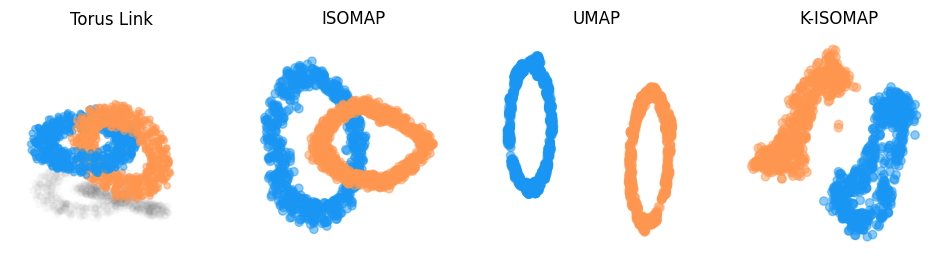

In [123]:
fig = plt.figure(figsize=(12,3))


# Double Torus
ax1 = fig.add_subplot(141, projection='3d')  
ax1.scatter(result_matrix[:,:3].T[0], result_matrix[:,:3].T[1], result_matrix[:,:3].T[2], c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)
ax1.view_init(elev=30, azim=30)
ax1.set_title('Torus Link',pad=16)  
ax1.axis('off')
ax1.set_xlim3d(-10, 5)
ax1.set_ylim3d(-10, 5)
ax1.set_zlim3d(-7, 5)
ax1.set_xlim(-10, 5)
ax1.set_ylim(-10, 5)
# Projecting the points onto the xy-plane by plotting them with a fixed z-coordinate that matches the lower z-limit.
ax1.scatter(result_matrix.T[0], result_matrix.T[1], -7*np.ones_like(result_matrix.T[2]), c='gray',alpha=0.02)


# ISOMAP
ax2 = fig.add_subplot(142)  
ax2.scatter(dados_isomap[0], dados_isomap[1],c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)
ax2.set_title('ISOMAP')  
ax2.axis('off')
ax2.set_xlim(-11, 14)
ax2.set_ylim(-9, 9)

# UMAP
ax3 = fig.add_subplot(143)  
ax3.scatter(embedding.T[0], embedding.T[1],  c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)
ax3.set_title('UMAP')  
ax3.axis('off')
ax3.set_xlim(-10, 20)
ax3.set_ylim(-1, 10)


# K-ISOMAP
ax4 = fig.add_subplot(144)  
ax4.scatter(dados_kisomap.T[0],dados_kisomap.T[1], c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)
ax4.set_title('K-ISOMAP')  
ax4.axis('off')
ax4.set_xlim(-10, 10)
ax4.set_ylim(-8, 7)

plt.savefig('linked_torus.tiff',format='tiff',dpi=300)
plt.savefig('linked_torus.jpeg',format='jpeg',dpi=300)
plt.show()

# Normal distribuition dataset

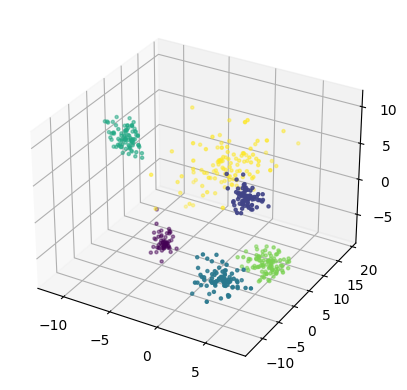

In [3]:
import repliclust 

archetype = repliclust.Archetype(
                    dim=3,
                    n_samples=500,
                    max_overlap=0.00001, min_overlap=0.000004 ,name="oblong"
                    )
X1, y1, _ = (repliclust.DataGenerator(archetype).synthesize(quiet=True))

X1 = X1.astype(np.float64)

# Parameters
noise_scale = 1  # adjust the noise gaussian parameter here

# Add noise
# Definir a magnitude do ruído gaussiano
magnitude = np.linspace(0,1,26)
# Gerar ruído gaussiano com média zero e desvio padrão baseado na magnitude
ruido = np.random.normal(0, scale=magnitude[0], size=X1.shape)
# Adicionar o ruído aos dados
# Surface equation
X1.T[0] = X1.T[0] + ruido.T[0]
X1.T[1] = X1.T[1] + ruido.T[1]
X1.T[2] = X1.T[2] + ruido.T[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(X1.T[0], X1.T[1], X1.T[2], c=y1, marker='.')

plt.show()

In [5]:
dados_kisomap_3 =  KIsomap(X1,k=40, d=2,option=10)
df_kisomap_3 = pd.DataFrame(dados_kisomap_3,columns=['x','y'])

model = Isomap(n_neighbors=40, n_components=2)
dados_isomap_3 = model.fit_transform(X1)
dados_isomap_3 = dados_isomap_3.T

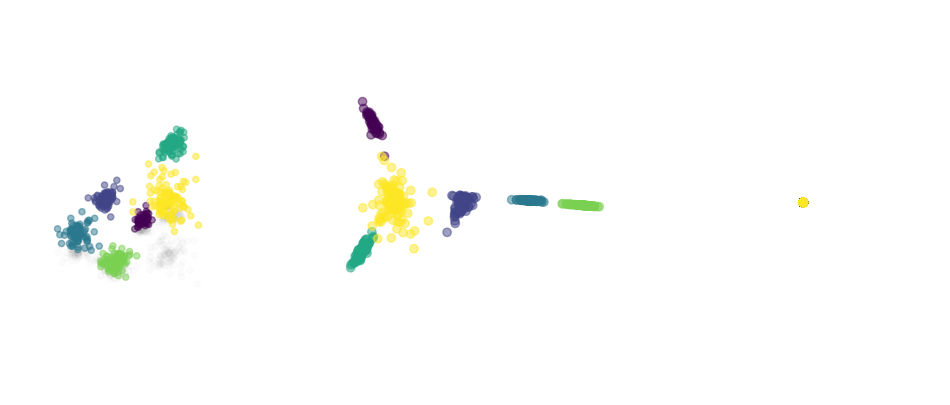

In [6]:
fig = plt.figure(figsize=(12,5))

# 3D
ax1 = fig.add_subplot(131,projection='3d')  
ax1.scatter(X1.T[0], X1.T[1], X1.T[2], c=y1, alpha=0.5)
ax1.view_init(elev=30, azim=30)
#ax1.set_title('Double torus')  
ax1.axis('off')
#ax1.set_xlim3d(-10, 5)
#ax1.set_ylim3d(-10, 5)
#ax1.set_zlim3d(-7, 5)
#ax1.set_xlim(-10, 5)
#ax1.set_ylim(-10, 5)
# Projecting the points onto the xy-plane by plotting them with a fixed z-coordinate that matches the lower z-limit.
ax1.scatter(X1.T[0], X1.T[1], -7*np.ones_like(X1.T[2]), c='gray',alpha=0.02)

# 2D
ax2 = fig.add_subplot(132)  
ax2.scatter(dados_isomap_3[0], dados_isomap_3[1],c=y1, alpha=0.5)
#ax2.set_title('ISOMAP Embedding')  
ax2.axis('off')
#ax2.set_xlim(-17, 17)
ax2.set_ylim(-25, 25)

# 2D
x_2d = df_kisomap_3['x']
y_2d = df_kisomap_3['y']
ax3 = fig.add_subplot(133)  
ax3.scatter(x_2d, y_2d, c=y1, alpha=0.5)
#ax3.set_title('K-ISOMAP Embedding')  
ax3.axis('off')
#ax3.set_xlim(-7, 7)
#ax3.set_ylim(-20, 20)

plt.savefig('gaussian_data_2_k_10.tiff',format='tiff',dpi=300)
plt.show()

# Casos triviais

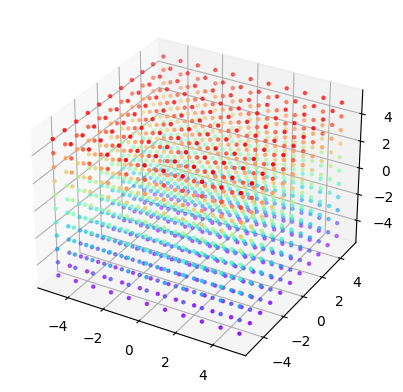

In [3]:
# Criando uma grade tridimensional
x = np.linspace(-5, 5, 11)  # 11 pontos de -5 a 5
y = np.linspace(-5, 5, 11)
z = np.linspace(-5, 5, 11)
X, Y, Z = np.meshgrid(x, y, z)

# Remodelando para obter um array 3D
X3 = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

X3 = X3.astype(np.float64)

# Parameters
noise_scale = 1  # adjust the noise gaussian parameter here

# Add noise
# Definir a magnitude do ruído gaussiano
magnitude = np.linspace(0,1,11)
# Gerar ruído gaussiano com média zero e desvio padrão baseado na magnitude
ruido = np.random.normal(0, scale=magnitude[0], size=X3.shape)
# Adicionar o ruído aos dados
# Surface equation
X3.T[0] = X3.T[0] + ruido.T[0]
X3.T[1] = X3.T[1] + ruido.T[1]
X3.T[2] = X3.T[2] + ruido.T[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(X3.T[0], X3.T[1], X3.T[2], c=[cm.rainbow(valor) for valor in X3.T[2]/10+0.5], marker='.')

plt.show()

# Teste do porquê da zero

In [138]:
dados = result_matrix[:,:3]
k = 5
d = 2
option = 10
alpha = 0

# Number of samples and features  
n = dados.shape[0]
m = dados.shape[1]
# Matrix to store the principal components for each neighborhood
matriz_pcs = np.zeros((n, m, m))
# Generate KNN graph
knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
A = knnGraph.toarray()
# Computes the means and covariance matrices for each patch
for i in range(n):       
    vizinhos = A[i, :]
    indices = vizinhos.nonzero()[0]
    if len(indices) == 0:                   # Treat isolated points
        matriz_pcs[i, :, :] = np.eye(m)     # Eigenvectors in columns
    else:
        # Get the neighboring samples
        amostras = dados[indices]
        v, w = np.linalg.eig(np.cov(amostras.T))
        # Sort the eigenvalues
        ordem = v.argsort()
        # Select the d eigenvectors associated to the d largest eigenvalues
        maiores_autovetores = w[:, ordem[::-1]]                 
        # Projection matrix
        Wpca = maiores_autovetores  # Eigenvectors in columns
        #print(Wpca.shape)
        matriz_pcs[i, :, :] = Wpca
    
# Defines the patch-based matrix (graph)
B = A.copy()
for i in range(n):
    for j in range(n):
        if B[i, j] > 0:
            delta = norm(matriz_pcs[i, :, :] - matriz_pcs[j, :, :], axis=0)
            
            ##### Functions of the principal curvatures (definition of the metric)
            # We must choose one single option for each execution
            if option == 0:
                B[i, j] = norm(delta)                  # metric A0 - Norms of the principal curvatures
            elif option == 1:
                B[i, j] = delta[0]                     # metric A1 - Curvature of the first principal component
            elif option == 2:
                B[i, j] = delta[-1]                    # metric A2 - Curvature of the last principal component
            elif option == 3:
                B[i, j] = (delta[0] + delta[-1])/2     # metric A3 - Average between the curvatures of first and last principal components
            elif option == 4:
                B[i, j] = np.sum(delta)/len(delta)     # metric A4 - Mean curvature
            elif option == 5:
                B[i, j] = max(delta)                   # metric A5 - Maximum curvature
            elif option == 6:
                B[i, j] = min(delta)                   # metric A6 - Minimum curvature
            elif option == 7:
                B[i, j] = min(delta)*max(delta)        # metric A7 - Product between minimum and maximum curvatures
            elif option == 8:
                B[i, j] = max(delta) - min(delta)      # metric A8 - Difference between maximum and minimum curvatures
            elif option == 9:
                B[i, j] = 1 - np.exp(-delta.mean())     # metric A9 - Negative exponential kernel
            else:
                B[i, j] = ((1-alpha)*A[i, j]) + alpha*norm(delta)      # alpha = 0 => regular ISOMAP, alpha = 1 => K-ISOMAP 
            
# Computes geodesic distances using the previous selected metric
G = nx.from_numpy_array(B)
D = nx.floyd_warshall_numpy(G)  
# Computes centering matrix H
H = np.eye(n, n) - (1/n)*np.ones((n, n))
# Computes the inner products matrix B
B = -0.5*H.dot(D**2).dot(H)    
# Remove infs and nans from B (if the graph is not connected)
maximo = np.nanmax(B[B != np.inf])   
B[np.isnan(B)] = 0
B[np.isinf(B)] = maximo
# Eigeendecomposition
lambdas, alphas = np.linalg.eig(B)
# Sort eigenvalues and eigenvectors
indices = lambdas.argsort()[::-1]
lambdas = lambdas[indices]
alphas = alphas[:, indices]
# Select the d largest eigenvectors
lambdas = lambdas[0:d]
alphas = alphas[:, 0:d]
# Computes the intrinsic coordinates
output = alphas*np.sqrt(lambdas)    
# Return the low dimensional coordinates
output = output.real

In [113]:
np.unique(A)

array([0.        , 0.0633535 , 0.07175365, ..., 1.40737655, 1.43115045,
       1.47169014])

In [140]:
nx.is_connected(G)

False

# É porque o grafo não fica conexo com curvaturas de aresta = 0

# -------

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
import matplotlib.patches as patches  # Add this import statement

In [68]:

def plot_grid_modified(base_data, dims, projection=None, view_init=None, axis_limits=None, save_as=None, dpi=300):
    """
    Adjusted function to vary the 'k' parameter automatically for different columns using the KIsomap algorithm.
    """
    fig = plt.figure(figsize=(4*dims[0], 4*dims[1]))
    x = np.linspace(-5, 5, 11)
    y = np.linspace(-5, 5, 11)
    z = np.linspace(-5, 5, 11)
    X, Y, Z = np.meshgrid(x, y, z)
    X3 = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
    X3 = X3.astype(np.float64)
    magnitude = np.linspace(0, 1, 4)
    nn=round(sqrt(base_data.shape[0]))

    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for row in range(dims[0]):
        for col in range(dims[1]):
            ax = fig.add_subplot(dims[0], dims[1], row*dims[1] + col + 1, projection='3d' if col == 0 else 'rectilinear')
            noise = np.random.normal(0, scale=magnitude[row], size=base_data.shape)
            X3_temp = base_data + noise
            
            if col == 0:
                # First column: 3D plots with increasing noise by row
                ax.scatter(X3_temp[:, 0], X3_temp[:, 1], X3_temp[:, 2], c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)
                if view_init:
                    ax.view_init(elev=view_init[0], azim=view_init[1])

            else:
                # Other columns: 2D plots applying KIsomap with varying 'k'
                k_values = {1: 25, 2: 30, 3: 35}  # Define k values for columns 1, 2, 3
                k = k_values.get(col, 4)  # Default to k=4 if col not in k_values
                dados_kisomap = KIsomap(X3_temp, k=k, d=2, option=0)
                ax.scatter(dados_kisomap[:, 0], dados_kisomap[:, 1], c=[cm.rainbow(valor) for valor in result_matrix.T[3]], alpha=0.5)

            ax.axis(False)
            ax.set_frame_on(True)



            

    if save_as:
        plt.savefig(save_as, format='tiff', dpi=dpi)
    #plt.axes('off')
    #ax.axes(False)
    plt.show()


In [69]:
round(sqrt(result_matrix.shape[0]))

37

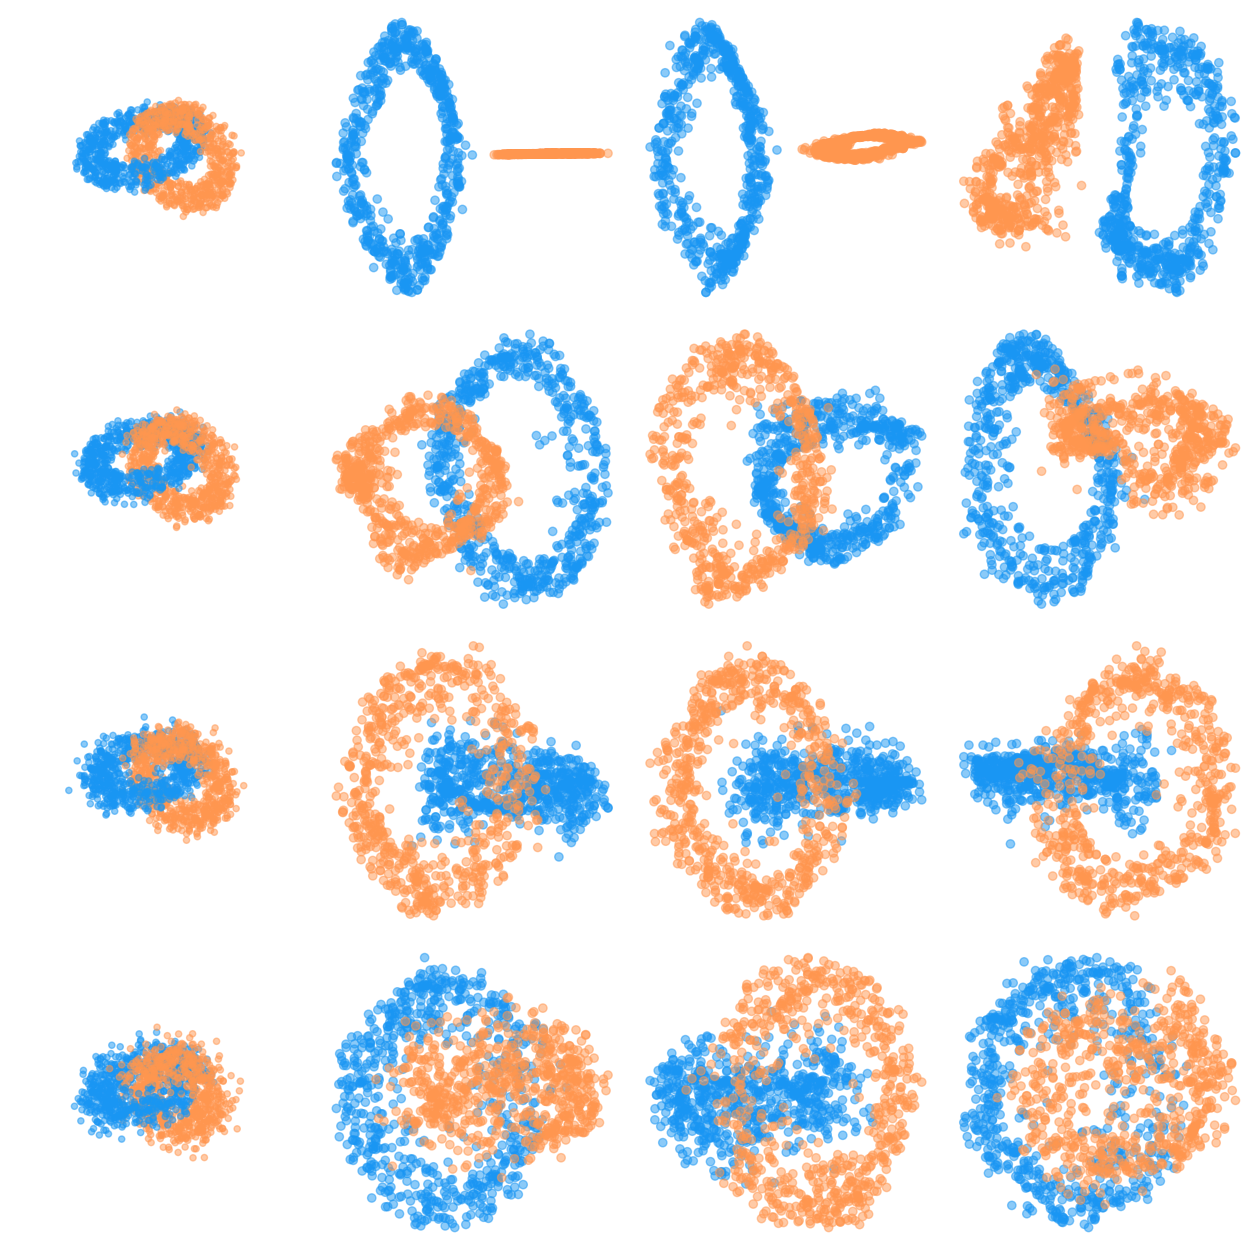

In [70]:
# Example data (assuming N = 12, not including the first column which is a 3D plot)

plot_grid_modified(result_matrix[:,:3], (4, 4), projection='3d', view_init=(30, 30), axis_limits={'xlim': (-10, 10), 'ylim': (-10, 10), 'zlim': (-10, 10)}, save_as='grid_plot_modified.tiff')

# Experimento

In [3]:
def generate_outliers(data):
    errs = np.var(data)/8 * np.random.rand(data.shape[1]) * np.random.choice((-1, 1), data.shape[1])
    data = data + errs

    lower_errs = np.std(data) * np.random.rand(data.shape[1])
    lower_outliers = np.mean(data) - lower_errs/4

    upper_errs = np.std(data)* np.random.rand(data.shape[1])
    upper_outliers = np.mean(data) + upper_errs/4

    outliers = np.vstack((lower_outliers, upper_outliers))
    return outliers

In [4]:
def generate_label_outliers(label):

    list = np.unique(label).tolist()
    # Generate a random index
    random_index = np.random.randint(0, len(list))

    # Access the element at the random index
    label_unique = list[random_index]

    outlier_label = np.array(label_unique)
    
    return outlier_label

In [142]:
# First set of experiments
datasets = [
#skdata.fetch_openml(name='servo', version=1), #    
##skdata.fetch_openml(name='car-evaluation', version=1),         
#skdata.fetch_openml(name='breast-tissue', version=2),
#skdata.fetch_openml(name='Engine1', version=1),                   
#skdata.fetch_openml(name='xd6', version=1),                 
#skdata.fetch_openml(name='heart-h', version=3),
#skdata.fetch_openml(name='steel-plates-fault', version=3)]
#---
#skdata.fetch_openml(name='PhishingWebsites', version=1),               # 10% of the samples
#skdata.fetch_openml(name='satimage', version=1),                     # 25% of the samples
#skdata.fetch_openml(name='led24', version=1),                     # 20% of the samples
skdata.fetch_openml(name='hayes-roth', version=2),
skdata.fetch_openml(name='rabe_131', version=2),
#skdata.fetch_openml(name='prnn_synth', version=1),           
skdata.fetch_openml(name='visualizing_environmental', version=2),
skdata.fetch_openml(name='diggle_table_a2', version=2),  
skdata.fetch_openml(name='newton_hema', version=2),   
skdata.fetch_openml(name='wisconsin', version=2),                  
skdata.fetch_openml(name='fri_c4_250_100', version=2),          
skdata.fetch_openml(name='conference_attendance', version=1),       
skdata.fetch_openml(name='tic-tac-toe', version=1),
skdata.fetch_openml(name='qsar-biodeg', version=1),
#skdata.fetch_openml(name='spambase', version=1),               # 25% of the samples
skdata.fetch_openml(name='cmc', version=1),
skdata.fetch_openml(name='heart-statlog', version=1)]

In [71]:
#-skdata.fetch_openml(name='cnae-9', version=1)]                          # 50-D 
#-skdata.fetch_openml(name='AP_Breast_Kidney', version=1)]                # 500-D
#-skdata.fetch_openml(name='AP_Endometrium_Breast', version=1)]           # 400-D
#-skdata.fetch_openml(name='AP_Ovary_Lung', version=1),                   # 100-D
#-skdata.fetch_openml(name='OVA_Uterus', version=1)]                     # 100-D
#-skdata.fetch_openml(name='micro-mass', version=1),                      # 100-D
#-skdata.fetch_openml(name='har', version=1)]                            # 10%  of the samples and 100-D       
#-skdata.fetch_openml(name='eating', version=1)]                          # 100-D       
#-skdata.fetch_openml(name='oh5.wc', version=1)]                          # 40-D
#-skdata.fetch_openml(name='leukemia', version=1)]                          # 40-D

In [10]:
results = {}

for X in datasets:

    ch_kiso = []
    ch_iso = []
    ri_kiso = []
    ri_iso = []
    fm_kiso = []
    fm_iso = []
    v_kiso = []
    v_iso = []
    

    
    dados = X['data'].copy()
    target = X['target']
    name = X['details']['name']
    
    print('############################')
    print('Initiating ', name,' dataset')

    # Convert labels to integers
    lista = []
    for x in target:
        if x not in lista:  
            lista.append(x)     

    # Map labels to respective numbers
    rotulos = []
    for x in target:  
        for i in range(len(lista)):
            if x == lista[i]:  
                rotulos.append(i)
    target_original = np.array(rotulos)

    # Number of samples, features and classes
    n = dados.shape[0]
    m = dados.shape[1]
    c = len(np.unique(target))

    # Some adjustments are require in opnML datasets
    # Categorical features must be encoded manually
    if type(dados) == sp.sparse._csr.csr_matrix:
        dados = dados.todense()
        dados = np.asarray(dados)
    if not isinstance(dados, np.ndarray):
        cat_cols = dados.select_dtypes(['category']).columns
        dados[cat_cols] = dados[cat_cols].apply(lambda x: x.cat.codes)
        # Convert to numpy
        dados = dados.to_numpy()

    # To remove NaNs
    dados = np.nan_to_num(dados)
        
    # OPTIONAL: set this flag to True to reduce the number of samples

    reduce_samples = False
    reduce_dim = True

    if not reduce_samples and not reduce_dim:
        raw_data = dados
    if reduce_samples:
        percentage = 0.10
        dados, garbage, target_original, garbage_t = train_test_split(dados, target, train_size=percentage, random_state=42)
        raw_data = dados
        
    # OPTIONAL: set this flag to True to reduce the dimensionality with PCA prior to metric learning
    if reduce_dim:
        num_features = 400
        raw_data = dados
        dados = PCA(n_components=num_features).fit_transform(dados)

    # Number of samples, features and classes
    n = dados.shape[0]
    m = dados.shape[1]
    # Print data info
    print('N = ', n)        
    print('M = ', m)        
    print('C = %d' %c)      
    # Number of neighbors in KNN graph (patch size)
    nn = round(np.floor(sqrt(n)))                 
    # GMM algorithm
    CLUSTER = 'gmm'
    ############## K-ISOMAP 
    # Number of neighbors
    print('K = ', nn)      
    #for ruido in ['gaussiano','salt_pepper']  

    # Data standardization (to deal with variables having different units/scales)
    dados = preprocessing.scale(dados).astype(np.float64)

    for r in range(11):      
        # Computes the results for all 10 curvature based metrics
        lista_ri = []
        lista_ch = []
        lista_fm = []
        lista_v = []
        inicio = time.time()

        # Noise parameters
        #noise_scale = 1  

        # Add noise
        # Definir a magnitude do ruído gaussiano
        scale = np.linspace(0,1,11)
     
        ruido = np.random.normal(0, scale=scale[r], size=dados.shape)

        dados_ruido = dados.copy() + ruido
        target = target_original.copy()
        
        #Adicionar 2% de outliers de acordo com numero de amostras
        #Adicionar grupo de outliers?
        #for s in range(round(n*0.02)):
        #    outlier = generate_outliers(dados_ruido)
        #    dados_ruido = np.vstack((dados_ruido,outlier))
        #    outlier_target = generate_label_outliers(target)
        #    target = np.hstack((target,outlier_target)).astype('float64')

        for i in range(11):
            dados_kiso = KIsomap(dados_ruido, nn, 2, i)       
            L_kiso = Clustering(dados_kiso.T, target, 'K-ISOMAP', CLUSTER)
            lista_ri.append(L_kiso[0])
            lista_ch.append(L_kiso[1])
            lista_fm.append(L_kiso[2])
            lista_v.append(L_kiso[3])
            labels_kiso = L_kiso[4]
        fim = time.time()
        print('K-ISOMAP time: %f s' %(fim - inicio))

        # Find best result in terms of Rand index
        ri_star = max(enumerate(lista_ri), key=lambda x: x[1])[0]
        dados_kiso = KIsomap(dados_ruido, nn, 2, ri_star) 
        L_kiso = Clustering(dados_kiso.T, target, 'K-ISOMAP', CLUSTER)
        #labels_kiso = L_kiso[4]
        ri_kiso.append(L_kiso[0])
        #PlotaDados(dados_kiso, labels_kiso, 'K-ISOMAP RI')

        fm_star = max(enumerate(lista_fm), key=lambda x: x[1])[0]
        dados_kiso = KIsomap(dados_ruido, nn, 2, fm_star) 
        L_kiso = Clustering(dados_kiso.T, target, 'K-ISOMAP', CLUSTER)
        #labels_kiso = L_kiso[4]
        fm_kiso.append(L_kiso[2])
        #PlotaDados(dados_kiso, labels_kiso, 'K-ISOMAP FM')

        # Find best result in terms of Rand index
        ch_star = max(enumerate(lista_ch), key=lambda x: x[1])[0]
        dados_kiso = KIsomap(dados_ruido, nn, 2, ch_star) 
        L_kiso = Clustering(dados_kiso.T, target, 'K-ISOMAP', CLUSTER)
        #labels_kiso = L_kiso[4]
        ch_kiso.append(L_kiso[1])
        #PlotaDados(dados_kiso, labels_kiso, 'K-ISOMAP CH')

        # Find best result in terms of V measure
        v_star = max(enumerate(lista_v), key=lambda x: x[1])[0]
        dados_kiso = KIsomap(dados_ruido, nn, 2, v_star) 
        L_kiso = Clustering(dados_kiso.T, target, 'K-ISOMAP', CLUSTER)
        labels_kiso = L_kiso[4]
        v_kiso.append(L_kiso[3])
        #PlotaDados(dados_kiso, labels_kiso, 'K-ISOMAP VS')

        ############## Regular ISOMAP 
        model = Isomap(n_neighbors=nn, n_components=2)
        dados_isomap = model.fit_transform(dados_ruido)
        dados_isomap = dados_isomap.T
        L_iso = Clustering(dados_isomap, target, 'ISOMAP', CLUSTER)
        #labels_iso = L_iso[4]
        #PlotaDados(dados_isomap.T, labels_iso, 'ISOMAP')
        ri_iso.append(L_iso[0])
        ch_iso.append(L_iso[1])
        fm_iso.append(L_iso[2])
        v_iso.append(L_iso[3])

        ############## RAW DATA
        #L_ = Clustering(dados_ruido.T, target, 'RAW DATA', CLUSTER)
        #labels_ = L_[4]
        #ri_r.append(L_[0])
        #ch_r.append(L_[1])
        #fm_r.append(L_[2])
        #v_r.append(L_[3])
        
        #print('Run #',r,' complete')
    

    results[name] = {"KISOMAP":[ri_kiso,ch_kiso,fm_kiso,v_kiso],
                     "ISOMAP":[ri_iso,ch_iso,fm_iso,v_iso]}
    
    print('Dataset ', name,' complete')
    print()

############################
Initiating  har  dataset
N =  1029
M =  100
C = 6
K =  32
K-ISOMAP time: 103.954009 s
K-ISOMAP time: 86.766862 s
K-ISOMAP time: 96.420772 s
K-ISOMAP time: 93.719748 s
K-ISOMAP time: 87.373669 s
K-ISOMAP time: 85.734186 s
K-ISOMAP time: 87.807878 s
K-ISOMAP time: 91.945618 s
K-ISOMAP time: 82.107464 s
K-ISOMAP time: 83.388083 s
K-ISOMAP time: 111.531701 s
Dataset  har  complete



In [363]:
with open('results_2_battery.json', 'w') as f:
    json.dump(results, f)

# Plot results

In [364]:
def min_max_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return standardized_data

In [102]:
def min_max_normalization(data):

    min_val = np.min(data, axis=0)  # Find minimum along each column (feature)
    max_val = np.max(data, axis=0)  # Find maximum along each column (feature)

    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data.tolist()  # Convert back to list of tuples (optional)

In [394]:
with open('/Users/user/Mestrado/K-ISOMAP/results-10052024-noise.json', 'r') as file:
    results = json.load(file)

In [ ]:
def generate_outliers(data):
    errs = np.var(data)/8 * np.random.rand(data.shape[1]) * np.random.choice((-1, 1), data.shape[1])
    data = data + errs

    lower_errs = np.std(data) * np.random.rand(data.shape[1])
    lower_outliers = np.mean(data) - lower_errs/4

    upper_errs = np.std(data)* np.random.rand(data.shape[1])
    upper_outliers = np.mean(data) + upper_errs/4

    outliers = np.vstack((lower_outliers, upper_outliers))
    return outliers

def generate_label_outliers(label):

    list = np.unique(label).tolist()
    # Generate a random index
    random_index1 = np.random.randint(0, len(list))
    random_index2 = np.random.randint(0, len(list))

    # Access the element at the random index
    label_unique1 = list[random_index1]
    label_unique2 = list[random_index2]

    outlier_label = np.array((label_unique1, label_unique2))
    return outlier_label

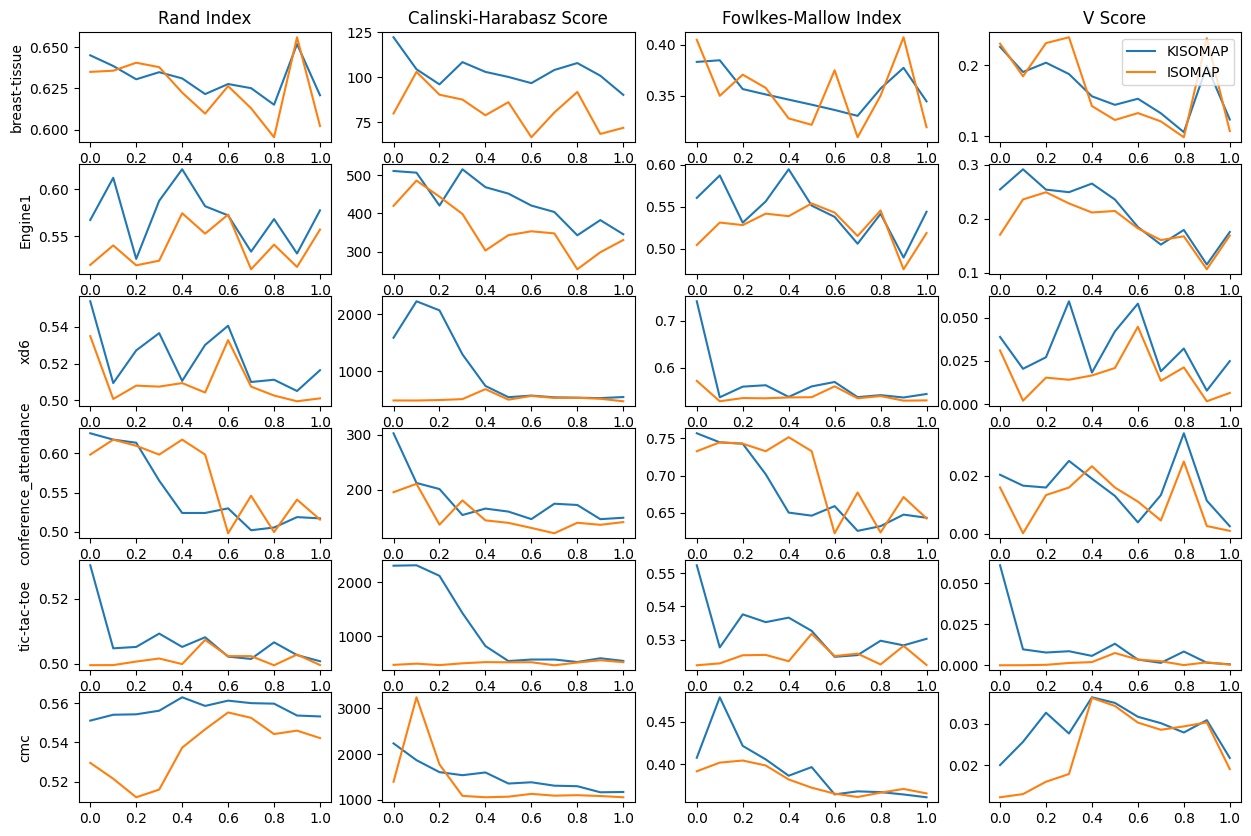

In [395]:
fig, axs = plt.subplots(6, 4, figsize=(15, 10))

datasets = [#'servo', 
#'car-evaluation', 
'breast-tissue', 
'Engine1', 
'xd6', 
#'heart-h', 
#'steel-plates-fault',
#'hayes-roth',
#'rabe_131',        
#'visualizing_environmental',
#'diggle_table_a2',
#'newton_hema',  
#'wisconsin',                 
#'fri_c4_250_100',         
'conference_attendance',     
'tic-tac-toe',
#'qsar-biodeg',
'cmc',
#'heart-statlog'
]

datasets_2 = [
'cnae-9',                    
#'AP_Breast_Kidney',    
#'AP_Endometrium_Breast',        
#'AP_Ovary_Lung',               
'OVA_Uterus',              
#'micro-mass',                  
'har',                        
'eating',                      
'oh5.wc',                        
'leukemia']                        

metrics = ['Rand Index', 'Calinski-Harabasz Score', 'Fowlkes-Mallow Index', 'V Score']
methods = ['KISOMAP', 'ISOMAP']
x = scale

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        ax = axs[i, j]  # Access individual subplot
        for method in methods:
            ax.plot(x, results[dataset][method][j], label=method)
            
        if j == 0:
            ax.set_ylabel(dataset)  # Set the y label here
            plt.setp(ax.get_yticklabels(), visible=True)
        else:
            plt.setp(ax.get_yticklabels(), visible=True) 
        if i == 0:
             ax.set_title(metric)  # Set the title here
        if i == 0 and j==3:
            ax.legend()  # Set the title here
             
#fig.suptitle('Noise analysis across datasets and quality metrics - Second battery', fontsize=16, ha='center',y=0.91)
plt.savefig('results_1_battery.jpg',dpi=300,format='jpeg')
plt.show()

# Swiss roll

In [281]:
import numpy as np
from sklearn.datasets import make_swiss_roll

# Generate the Swiss Roll dataset with 1500 samples
X2, color = make_swiss_roll(n_samples=2000,hole=False)

X2 = np.array(X2)
# Convert the dataset into a matrix array


In [228]:
def generate(data):
    #errs = np.var(data) * np.random.rand(data.shape[1]) * np.random.choice((-1, 1), data.shape[1])
    #data = data + errs

    lower_errs = np.std(data) * np.random.rand(data.shape[1])
    lower_outliers = np.mean(data)/8 - 1.7*lower_errs

    upper_errs = np.std(data)* np.random.rand(data.shape[1])
    upper_outliers = np.mean(data)/8 + 1.7*upper_errs

    outliers = np.vstack((lower_outliers, upper_outliers))
    return outliers

In [151]:
dados_outlier = X2

for i in range(round(X2.shape[0]*0.025)):
    outlier = generate(X2)
    dados_outlier = np.vstack((dados_outlier,outlier))

color_outlier = np.hstack((color,np.full(round(X2.shape[0]*0.05+1), 0).tolist()))

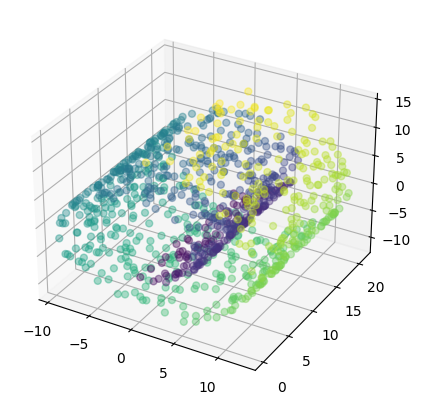

In [272]:
fig = plt.figure(figsize=(12,5))

# 3D
ax1 = fig.add_subplot(121,projection='3d')  
ax1.scatter(X2.T[0], X2.T[1], X2.T[2], c=color, marker='.',s=100,alpha=0.4)
ax1.set_title('')  
#ax1.view_init(elev=145, azim=145) 

plt.show()

In [282]:
model = Isomap(n_neighbors=11, n_components=2)
dados_isomap = model.fit_transform(X2)
dados_isomap = dados_isomap.T

kiso = KIsomap(X2, 11, 2, 0)

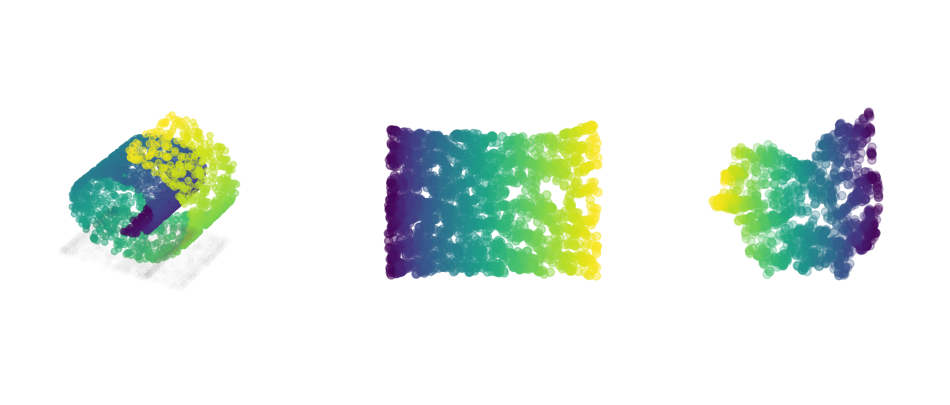

In [283]:
fig = plt.figure(figsize=(12,5))

# 3D
ax1 = fig.add_subplot(131,projection='3d')  
ax1.scatter(X2.T[0], X2.T[1], X2.T[2], c=color, alpha=0.5)
#ax1.view_init(elev=30, azim=30)
#ax1.set_title('Double torus')  
ax1.axis('off')
#ax1.set_xlim3d(-10, 5)
#ax1.set_ylim3d(-10, 5)
#ax1.set_zlim3d(-7, 5)
#ax1.set_xlim(-10, 5)
#ax1.set_ylim(-10, 5)
# Projecting the points onto the xy-plane by plotting them with a fixed z-coordinate that matches the lower z-limit.
ax1.scatter(X2.T[0]+3, X2.T[1]-10, -7*np.ones_like(X2.T[2]),
            c='gray',alpha=0.005)

# 2D
ax2 = fig.add_subplot(132)  
ax2.scatter(dados_isomap[0], dados_isomap[1],c=color, alpha=0.5)
#ax2.set_title('ISOMAP Embedding')  
ax2.axis('off')
ax2.set_xlim(-60, 60)
ax2.set_ylim(-30, 30)

# 2D
x_2d = kiso.T[0]
y_2d = kiso.T[1]
ax3 = fig.add_subplot(133)  
ax3.scatter(x_2d/2, y_2d/2, c=color, alpha=0.3)
#ax3.set_title('K-ISOMAP Embedding')  
ax3.axis('off')
ax3.set_xlim(-30, 30)
ax3.set_ylim(-13, 13)

plt.savefig('swiss_roll_kisomap.tiff',format='tiff',dpi=300)
plt.show()

# Conclusions

In [72]:
#Bases sintéticas
#Bases open ml
#Ruido variando de 0 a 1 com dados normalizados
#Adição de outliers

Estava pensando que uma justificativa de porque usar o método K-ISOMAP para realizar agrupamentos por GMM, é que numa variedade d-dimensional exister d direções de curvaturas principais. Elas podem ser iguais entre si ou distintas, pois o que o K-ISOMAP faz, é estimar esses valores de curvaturas principais para que possam ser agrupados de acordo com a estrutura local de curvatura. E o GMM, agrupa objetos em cluster elípticos, tal qual o K-ISOMAP captura  no embedding.

K-ISOMAP pode falhar por questões de densidado quanto ao número de vizinhos no gráfico de vizinhança.

Reconstruir a variedade com a curvatura em cada ponto? MDS talvez não seja tão adequado, pois curvatura não tem haver apenas com distância

Aplicar a normalização para captar a diferença entre as curvas sob a mesma escala de comparação

Pegar os 4 5 melhores, e as 4 5 piores

Focado na extração de características pré agrupamento

Ground truth em validação externa (HDBSCAN só funciona com indices internos)

SC, Davies Bouldin

# Re-run RAW data

In [142]:
def gaussian(dataset, scale_mag):
    # Generate noise
    noise = np.random.normal(0, scale=scale_mag, size=dataset.shape)
    
    # Apply noise in feature level
    dataset_with_noise = dataset.copy() + noise
    
    return dataset_with_noise

def salt_pepper(dataset, scale_mag):
    return 'salt_pepper'

def poison(dataset, scale_mag):
    return 'poison'

def apply_noise_type(noise_type, dataset, scale_mag):
    switch = {
        'gaussian': gaussian,
        'salt_pepper': salt_pepper,
        'poision': poison
    }
    func = switch.get(noise_type, lambda: print("Invalid noise type"))
    
    return func(dataset, scale_mag)

In [143]:
datasets = [
     #First set of experiments
           
     {"db": skdata.fetch_openml(name='servo', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='car-evaluation', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='breast-tissue', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='Engine1', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='xd6', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='heart-h', version=3), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='steel-plates-fault', version=3), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='PhishingWebsites', version=1), "reduce_samples": True, "percentage":.1},         # 10% of the samples
     {"db": skdata.fetch_openml(name='satimage', version=1), "reduce_samples": True, "percentage":.25},                # 25% of the samples
     {"db": skdata.fetch_openml(name='led24', version=1), "reduce_samples": True, "percentage":.20},                   # 20% of the samples
     {"db": skdata.fetch_openml(name='hayes-roth', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='rabe_131', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='prnn_synth', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='visualizing_environmental', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='diggle_table_a2', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='newton_hema', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='wisconsin', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='fri_c4_250_100', version=2), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='conference_attendance', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='tic-tac-toe', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='qsar-biodeg', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='spambase', version=1), "reduce_samples": True, "percentage":.25},                # 25% of the samples
     {"db": skdata.fetch_openml(name='cmc', version=1), "reduce_samples": False, "percentage":0},
     {"db": skdata.fetch_openml(name='heart-statlog', version=1), "reduce_samples": False, "percentage":0}
     #{"db": {'data':X_Cube,'target':X_Cube_Labels,'details':{'name':"3D_Cube"}}, "reduce_samples": False, "percentage":0}
     #{"db": {'data':X_Torus,'target':X_Torus_Labels,'details':{'name':"Double_Torus"}}, "reduce_samples": False, "percentage":0}
    # Second set of experiments
    
    #skdata.fetch_openml(name='AP_Breast_Kidney', version=1),                # 500-D
    #skdata.fetch_openml(name='AP_Endometrium_Breast', version=1),           # 400-D
    #skdata.fetch_openml(name='AP_Ovary_Lung', version=1),                   # 100-D
    #skdata.fetch_openml(name='OVA_Uterus', version=1),                      # 100-D
    #skdata.fetch_openml(name='micro-mass', version=1),                      # 100-D
    #X = skdata.fetch_openml(name='har', version=1)                             # 10%  of the samples and 100-D       
    #skdata.fetch_openml(name='eating', version=1),                          # 100-D       
    # skdata.fetch_openml(name='oh5.wc', version=1),                          # 40-D
    # skdata.fetch_openml(name='leukemia', version=1),                        # 40-D
    # skdata.fetch_openml(name='cnae-9', version=1),                          # 50-D 
]

plot_results = False
apply_noise = True

# ['gaussian', 'salt_pepper', 'poison']
noise_type = 'gaussian'

if apply_noise:
    # Noise parameters
    # Standard deviation (spread or “width”) of the distribution. Must be non-negative
    data_std_dev = 1 # for normalized data base
    
    # Define magnitude
    magnitude = np.linspace(0, data_std_dev, 11)
else:
    magnitude = np.linspace(0, 0, 1)

# GMM algorithm
CLUSTER = 'gmm'

# File result
file_results = 'results_raw_datasets.json'
results = {}
for dataset in datasets:
    
    X = dataset["db"]
    dataset_data = X['data']
    dataset_target = X['target']
    dataset_name = X['details']['name']
    # Convert labels to integers
    label_list = []
    for x in dataset_target:
        if x not in label_list:  
            label_list.append(x)     
            
    # Map labels to respective numbers
    labels = []
    for x in dataset_target:  
        for i in range(len(label_list)):
            if x == label_list[i]:  
                labels.append(i)
    dataset_target = np.array(labels)
    # Number of samples, features and classes
    n = dataset_data.shape[0]
    m = dataset_data.shape[1]
    c = len(np.unique(dataset_target))
    # Some adjustments are require in opnML datasets
    # Categorical features must be encoded manually
    if type(dataset_data) == sp.sparse._csr.csr_matrix:
        dataset_data = dataset_data.todense()
        dataset_data = np.asarray(dataset_data)
    if not isinstance(dataset_data, np.ndarray):
        cat_cols = dataset_data.select_dtypes(['category']).columns
        dataset_data[cat_cols] = dataset_data[cat_cols].apply(lambda x: x.cat.codes)
        # Convert to numpy
        dataset_data = dataset_data.to_numpy()
    # To remove NaNs
    dataset_data = np.nan_to_num(dataset_data)
    # Data standardization (to deal with variables having different units/scales)
    dataset_data = preprocessing.scale(dataset_data).astype(np.float64)
    # OPTIONAL: set this flag to True to reduce the number of samples
    reduce_samples = dataset["reduce_samples"]
    reduce_dim = False
    if not reduce_samples and not reduce_dim:
        raw_data = dataset_data
    if reduce_samples:
        percentage = dataset["percentage"]
        dataset_data, garbage, dataset_target, garbage_t = train_test_split(dataset_data, dataset_target, train_size=percentage, random_state=42)
        raw_data = dataset_data
    # OPTIONAL: set this flag to True to reduce the dimensionality with PCA prior to metric learning
    if reduce_dim:
        num_features = 50
        raw_data = dataset_data
        dataset_data = PCA(n_components=num_features).fit_transform(dataset_data)
    # Number of samples, features and classes
    n = dataset_data.shape[0]
    m = dataset_data.shape[1]
    # Print data info
    print('N = ', n)
    print('M = ', m)
    print('C = %d' %c)
    
    # Number of neighbors in KNN graph (patch size)
    nn = 5#round(sqrt(n))                 
    
    ############## K-ISOMAP 
    # Number of neighbors
    #print('K = ', nn)      
    #print()
    #print('Press enter to continue...')
    #input()
    # K-ISOMAP results
    
    # RAW results
    ri_raw, ch_raw, fm_raw, v_raw = [], [], [], []
    ri_raw_norm, ch_raw_norm, fm_raw_norm, v_raw_norm = [], [], [], []
        
    for r in range(len(magnitude)):
        # Computes the results for all 10 curvature based metrics
        start = time.time()
        
        if apply_noise:
            dataset_data = apply_noise_type(noise_type, dataset_data, magnitude[r])
            raw_data = apply_noise_type(noise_type, raw_data, magnitude[r])

        
        ############## RAW DATA
        print(dataset_name + ' RAW DATA result')
        print('-----------------')
        DR_method = 'RAW ' + dataset_name + ' cluster=' + CLUSTER
        L_ = Clustering(raw_data.T, dataset_target, DR_method, CLUSTER)
        ri_raw.append(L_[0])
        ch_raw.append(L_[1])
        fm_raw.append(L_[2])
        v_raw.append(L_[3])
        
    results[dataset_name] = {"RAW": [ri_raw, ch_raw, fm_raw, v_raw]}
    
    
    print('Dataset ', dataset_name,' complete')
    print()
    
    # Check previous results
    try:
        with open(file_results, 'r') as f:
            previous_results = json.load(f)
    except FileNotFoundError:
        previous_results = {}
            
    results = {key: {**results.get(key, {}), **previous_results.get(key, {})} for key in results.keys() | previous_results.keys()}
    # Save results
    try:
        with open(file_results, 'w') as f:
            json.dump(results, f)
    except IOError as e:
        print(f"An error occurred while writing to the file: {file_results} - {e}")
    
    
    ############## RAW DATA
    print('RAW DATA result')
    print('-----------------')
    L_ = Clustering(raw_data.T, dataset_target, 'RAW DATA', CLUSTER)
    labels_ = L_[4]
    #PlotaDados(raw_data.T, labels_, 'RAW DATA')

N =  167
M =  4
C = 2
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
servo RAW DATA result
-----------------
Dataset  servo  complete

RAW DATA result
-----------------
N =  1728
M =  21
C = 4
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluation RAW DATA result
-----------------
car-evaluatio